<a href="https://colab.research.google.com/github/Bahrombekk/pytorch/blob/main/%D0%9A%D0%BE%D0%BF%D0%B8%D1%8F_%D0%B1%D0%BB%D0%BE%D0%BA%D0%BD%D0%BE%D1%82%D0%B0_%22%D0%9A%D0%BE%D0%BF%D0%B8%D1%8F_%D0%B1%D0%BB%D0%BE%D0%BA%D0%BD%D0%BE%D1%82%D0%B0_%22Cat_and_Dog_VGG11(Practices)_ipynb%22%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip

--2023-07-06 16:20:27--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.119.128, 108.177.126.128, 108.177.127.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.119.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘cats_and_dogs_filtered.zip’

cats_and_dogs_filte 100%[===================>]  65.43M  28.7MB/s    in 2.3s    

2023-07-06 16:20:29 (28.7 MB/s) - ‘cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [2]:
!unzip -d data cats_and_dogs_filtered.zip

Archive:  cats_and_dogs_filtered.zip
   creating: data/cats_and_dogs_filtered/
  inflating: data/cats_and_dogs_filtered/vectorize.py  
   creating: data/cats_and_dogs_filtered/validation/
   creating: data/cats_and_dogs_filtered/train/
   creating: data/cats_and_dogs_filtered/validation/dogs/
  inflating: data/cats_and_dogs_filtered/validation/dogs/dog.2127.jpg  
  inflating: data/cats_and_dogs_filtered/validation/dogs/dog.2126.jpg  
  inflating: data/cats_and_dogs_filtered/validation/dogs/dog.2125.jpg  
  inflating: data/cats_and_dogs_filtered/validation/dogs/dog.2124.jpg  
  inflating: data/cats_and_dogs_filtered/validation/dogs/dog.2123.jpg  
  inflating: data/cats_and_dogs_filtered/validation/dogs/dog.2122.jpg  
  inflating: data/cats_and_dogs_filtered/validation/dogs/dog.2121.jpg  
  inflating: data/cats_and_dogs_filtered/validation/dogs/dog.2120.jpg  
  inflating: data/cats_and_dogs_filtered/validation/dogs/dog.2119.jpg  
  inflating: data/cats_and_dogs_filtered/validation/dogs/d

In [3]:
!pip install torchinfo

In [4]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset,DataLoader,random_split
import torch.nn.functional as F
import glob

from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
# from torchinfo import summary
from torchsummary import summary
import pathlib
from PIL import Image
from torchvision.transforms import transforms
from torch.optim import Adam

import torchvision.transforms as T

In [5]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# DATA PREPARATION

In [6]:
train_path = pathlib.Path('/content/data/cats_and_dogs_filtered/train')
test_path = pathlib.Path('/content/data/cats_and_dogs_filtered/validation')

In [7]:
transform = T.Compose([
    T.Resize(size=(150,150)),
    T.ToTensor()
])

In [8]:
class CATinDOGtaset(Dataset):

    def __init__(self, path, transform = None):
        # int for cross entryp loss
        self.path_list = list(path.glob('*/*.jpg'))
        self.transform = transform

    def __getitem__(self,index):
        img = Image.open(self.path_list[index])
        label = (self.path_list[index]).parts[-2]
        label = 0 if 'cat' in label else 1
        if transform != None:
            img = transform(img)

        return img, int(label)

    def __len__(self):
        return len(self.path_list)

In [9]:
train_dataset = CATinDOGtaset(train_path, transform)
test_dataset = CATinDOGtaset(test_path, transform)

In [10]:
path_list = list(train_path.glob('*/*.jpg'))
path_test=list(test_path.glob('*/*.jpg'))

In [11]:
train_data = DataLoader(train_dataset, batch_size=256, shuffle=True)
test_data = DataLoader(test_dataset, batch_size=256, shuffle=True)

# MODEL

In [12]:
class ConvNet(nn.Module):
    def __init__(self,num_classes=2):
        super(ConvNet,self).__init__()

        #Output size after convolution filter
        #((w-f+2P)/s) +1

        #Input shape= (256,3,150,150)

        self.conv1=nn.Conv2d(in_channels=3,out_channels=12,kernel_size=3,stride=1,padding=1)
        #Shape= (256,12,150,150)
        self.bn1=nn.BatchNorm2d(num_features=12)
        #Shape= (256,12,150,150)
        self.relu1=nn.ReLU()
        #Shape= (256,12,150,150)

        self.pool=nn.MaxPool2d(kernel_size=2)
        #Reduce the image size be factor 2
        #Shape= (256,12,75,75)

        self.conv2=nn.Conv2d(in_channels=12,out_channels=20,kernel_size=3,stride=1,padding=1)
        #Shape= (256,20,75,75)
        self.relu2=nn.ReLU()
        #Shape= (256,20,75,75)

        self.conv3=nn.Conv2d(in_channels=20,out_channels=32,kernel_size=3,stride=1,padding=1)
        #Shape= (256,32,75,75)
        self.bn3=nn.BatchNorm2d(num_features=32)
        #Shape= (256,32,75,75)
        self.relu3=nn.ReLU()
        #Shape= (256,32,75,75)

        self.fc=nn.Linear(in_features=75 * 75 * 32,out_features=num_classes)

        #Feed forwad function

    def forward(self,input):
        output=self.conv1(input)
        output=self.bn1(output)
        output=self.relu1(output)

        output=self.pool(output)

        output=self.conv2(output)
        output=self.relu2(output)

        output=self.conv3(output)
        output=self.bn3(output)
        output=self.relu3(output)

        #Above output will be in matrix form, with shape (256,32,75,75)

        output=output.view(-1,32*75*75)

        output=self.fc(output)

        return output


In [13]:
model=ConvNet()

In [ ]:
#model = ConvNet(num_classes=2)

In [ ]:
#model = model.to(device)

In [14]:
learning_rate = 0.001
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)

In [15]:
num_epochs = 5

In [16]:
class Trainer:
    def __init__(self, model, train_dataloader, test_dataloader, criterion, optimizer, epochs=3):
        self.model = model
        self.train_dataloader = train_dataloader
        self.test_dataloader = test_dataloader
        self.criterion = criterion
        self.optimizer = optimizer

        self.epochs = epochs
        self.history = {'loss':[],'acc':[],'val_loss':[],'val_acc':[]}

    def train_loop(self):
        sum_loss = 0
        sum_accuracy = 0
        n = len(self.train_dataloader)
        for i, (data,label) in enumerate(tqdm(self.train_dataloader)):
            data = data.to(device)
            label = label.to(device)
            # prediction model
            output = self.model(data)
            # find loss
            loss = self.criterion(output, label)

            sum_loss += loss.item()
            n_corrects = (output.argmax(axis=1)==label).sum().item()
            sum_accuracy += n_corrects/label.size(0)

            loss.backward()
            self.optimizer.step()
            self.optimizer.zero_grad()


        train_loss = sum_loss/n
        train_accuracy = sum_accuracy/n

        self.history['loss'].append(train_loss)
        self.history['acc'].append(train_accuracy)

        return train_loss, train_accuracy

    def validation_loop(self):
        sum_loss = 0
        sum_accuracy = 0
        n = len(self.test_dataloader)
        for i, (data,label) in enumerate(tqdm(self.test_dataloader)):
            data = data.to(device)
            label = label.to(device)
            # prediction model
            output = self.model(data)
            # find loss
            loss = self.criterion(output, label)
            n_corrects = (output.argmax(axis=1)==label).sum().item()

            sum_loss += loss.item()
            sum_accuracy += n_corrects/label.size(0)

        val_loss = sum_loss/n
        val_accuracy = sum_accuracy/n

        self.history['val_loss'].append(val_loss)
        self.history['val_acc'].append(val_accuracy)

        return val_loss, val_accuracy

    def train(self):
        for epoch in range(num_epochs):
            train_loss, train_acc = self.train_loop()
            val_loss, val_acc = self.validation_loop()
            print()
            print(f'Epoch[{epoch+1}/{num_epochs}] \t train_loss: {train_loss:.5f}, train_acc: {train_acc:.2f} \t val_loss: {val_loss:.5f} \t val_acc: {val_acc:.2}')


In [17]:
trainer = Trainer(
    model = model.to(device),
    train_dataloader = train_data,
    test_dataloader = test_data,
    criterion=criterion,
    optimizer=optimizer
)

In [36]:
trainer.train()

100%|██████████| 4/4 [00:18<00:00,  4.66s/it]



Epoch[1/5] 	 train_loss: 0.46057, train_acc: 0.84 	 val_loss: 1.95947 	 val_acc: 0.6


100%|██████████| 4/4 [00:17<00:00,  4.42s/it]



Epoch[2/5] 	 train_loss: 0.63248, train_acc: 0.79 	 val_loss: 1.87104 	 val_acc: 0.61


100%|██████████| 4/4 [00:20<00:00,  5.20s/it]



Epoch[3/5] 	 train_loss: 0.52972, train_acc: 0.83 	 val_loss: 2.56148 	 val_acc: 0.58


100%|██████████| 4/4 [00:17<00:00,  4.39s/it]



Epoch[4/5] 	 train_loss: 0.35670, train_acc: 0.88 	 val_loss: 1.68471 	 val_acc: 0.63


100%|██████████| 4/4 [00:18<00:00,  4.57s/it]


Epoch[5/5] 	 train_loss: 0.17691, train_acc: 0.93 	 val_loss: 1.66815 	 val_acc: 0.63


In [37]:
test_img, test_label = next(iter(test_data))

In [38]:
pred = model(test_img.to(device))

In [39]:
pred = pred.argmax(axis=1)

In [40]:
pred.device

device(type='cpu')

In [41]:
pred = pred.detach().cpu()

In [42]:
from sklearn.metrics import confusion_matrix

In [43]:
test_label

tensor([1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0,
        1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1,
        0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0,
        0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1,
        0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0,
        1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0,
        1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0,
        0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0,
        1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1,
        1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1,
        1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0])

In [44]:
cm = confusion_matrix(test_label, pred)

In [45]:
cm

array([[53, 82],
       [25, 96]])

<Axes: >

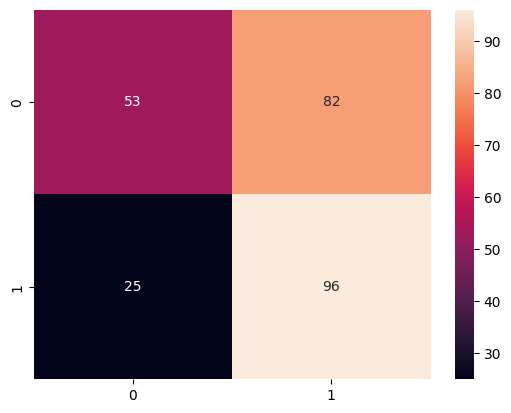

In [46]:
import seaborn as sns
sns.heatmap(cm, annot=True)